In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV, RFE
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

In [2]:
# -------------------- Read Data --------------------
data_df = pd.read_csv("CO2 Emissions_Canada.csv")
print("Original data shape:", data_df.shape)

# Define features and target variable
features = ["Engine Size(L)", "Cylinders", "Fuel Consumption City (L/100 km)", 
            "Fuel Consumption Hwy (L/100 km)", "Fuel Consumption Comb (L/100 km)", 
            "Fuel Consumption Comb (mpg)", "Make", "Model", "Vehicle Class", 
            "Transmission", "Fuel Type"]
target = "CO2 Emissions(g/km)"

# List numerical and categorical features
numeric_features = ["Engine Size(L)", "Cylinders", "Fuel Consumption City (L/100 km)", 
                    "Fuel Consumption Hwy (L/100 km)", "Fuel Consumption Comb (L/100 km)", 
                    "Fuel Consumption Comb (mpg)"]
categorical_features = ["Make", "Model", "Vehicle Class", "Transmission", "Fuel Type"]

Original data shape: (7385, 12)


In [3]:
# -------------------- 1. Data Splitting --------------------
print("\n[1] Data Splitting")
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42)
print("Training set shape:", train_df.shape)
print("Test set shape:", test_df.shape)


[1] Data Splitting
Training set shape: (5908, 12)
Test set shape: (1477, 12)


In [4]:
# -------------------- 2. Apply KFold Target Encoding on Training Data --------------------
print("\n[2] Apply KFold Target Encoding on Training Data")

# Initialize KFold with 5 splits, shuffling enabled for randomness
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Create a copy of the training dataset to store encoded values
train_encoded_df = train_df.copy()

# Perform KFold Target Encoding for each categorical feature
for cat in categorical_features:
    # Create a new column for the encoded values, initially set to NaN
    train_encoded_df[f"{cat}_encoded"] = np.nan  

    # Apply KFold encoding
    for train_idx, val_idx in kf.split(train_df):
        # Select the training fold
        fold_train = train_df.iloc[train_idx]  

        # Compute mean target value for each category in the training fold
        target_mean = fold_train.groupby(cat)[target].mean()  

        # Ensure only valid indices are used to avoid KeyErrors
        valid_idx = train_encoded_df.index.intersection(val_idx)

        # Assign encoded values using the computed mean from the training fold
        train_encoded_df.loc[valid_idx, f"{cat}_encoded"] = train_df.loc[valid_idx, cat].map(target_mean)

    # Handle unseen categories by replacing NaN values with the overall target mean
    train_encoded_df[f"{cat}_encoded"].fillna(train_df[target].mean(), inplace=True)

    print(f"Completed KFold target encoding for feature: {cat}")

# Display a preview of the encoded training dataset
print("\nTraining dataset after KFold target encoding (first 5 rows):")
print(train_encoded_df.head())

# Check and report missing values
print("\nChecking for missing values in the training dataset:")
missing_values = train_encoded_df.isnull().sum()
print(missing_values)

# Display the final status of missing values
if missing_values.sum() == 0:
    print("No missing values found in the training dataset.")
else:
    print("Missing values detected in the training dataset.")


[2] Apply KFold Target Encoding on Training Data
Completed KFold target encoding for feature: Make
Completed KFold target encoding for feature: Model
Completed KFold target encoding for feature: Vehicle Class
Completed KFold target encoding for feature: Transmission
Completed KFold target encoding for feature: Fuel Type

Training dataset after KFold target encoding (first 5 rows):
         Make        Model             Vehicle Class  Engine Size(L)  \
6590      BMW  M240i Coupe                SUBCOMPACT             3.0   
6274   NISSAN     Frontier      PICKUP TRUCK - SMALL             4.0   
2251     AUDI   S4 QUATTRO                   COMPACT             3.0   
3149  PORSCHE     CAYMAN S                TWO-SEATER             3.4   
4362    VOLVO       V90 T5  STATION WAGON - MID-SIZE             2.0   

      Cylinders Transmission Fuel Type  Fuel Consumption City (L/100 km)  \
6590          6          AS8         Z                              11.4   
6274          6           A5  

C:\Users\18611\AppData\Local\Temp\ipykernel_9720\852649224.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_encoded_df[f"{cat}_encoded"].fillna(train_df[target].mean(), inplace=True)
C:\Users\18611\AppData\Local\Temp\ipykernel_9720\852649224.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

In [5]:
# -------------------- 3. Apply Target Encoding on Test Data --------------------
print("\n[3] Apply Target Encoding on Test Data")
test_encoded_df = test_df.copy()
for cat in categorical_features:
    overall_mapping = train_df.groupby(cat)[target].mean()
    test_encoded_df[cat + "_encoded"] = test_df[cat].map(overall_mapping)
    # Fill missing values with the overall training target mean
    test_encoded_df[cat + "_encoded"].fillna(train_df[target].mean(), inplace=True)
    print(f"Completed target encoding for {cat} in test data")

# Remove original categorical features
train_encoded_df.drop(columns=categorical_features, inplace=True)
test_encoded_df.drop(columns=categorical_features, inplace=True)

print("\nMissing values in test set:")
missing_test_counts = test_encoded_df.isnull().sum()
print(missing_test_counts)

if missing_test_counts.sum() == 0:
    print("No missing values in test set")
else:
    print("There are missing values in test set")


[3] Apply Target Encoding on Test Data
Completed target encoding for Make in test data
Completed target encoding for Model in test data
Completed target encoding for Vehicle Class in test data
Completed target encoding for Transmission in test data
Completed target encoding for Fuel Type in test data

Missing values in test set:
Engine Size(L)                      0
Cylinders                           0
Fuel Consumption City (L/100 km)    0
Fuel Consumption Hwy (L/100 km)     0
Fuel Consumption Comb (L/100 km)    0
Fuel Consumption Comb (mpg)         0
CO2 Emissions(g/km)                 0
Make_encoded                        0
Model_encoded                       0
Vehicle Class_encoded               0
Transmission_encoded                0
Fuel Type_encoded                   0
dtype: int64
No missing values in test set


C:\Users\18611\AppData\Local\Temp\ipykernel_9720\579498718.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_encoded_df[cat + "_encoded"].fillna(train_df[target].mean(), inplace=True)
C:\Users\18611\AppData\Local\Temp\ipykernel_9720\579498718.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always 


[4] Correlation Analysis


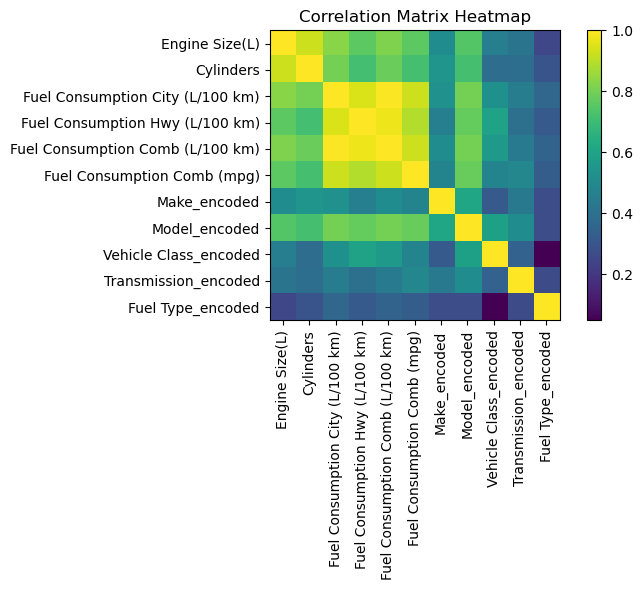

Highly correlated feature pairs:
Engine Size(L) and Cylinders have correlation: 0.93
Fuel Consumption City (L/100 km) and Fuel Consumption Hwy (L/100 km) have correlation: 0.95
Fuel Consumption City (L/100 km) and Fuel Consumption Comb (L/100 km) have correlation: 0.99
Fuel Consumption City (L/100 km) and Fuel Consumption Comb (mpg) have correlation: 0.93
Fuel Consumption Hwy (L/100 km) and Fuel Consumption Comb (L/100 km) have correlation: 0.98
Fuel Consumption Comb (L/100 km) and Fuel Consumption Comb (mpg) have correlation: 0.93
Randomly retained features: ['Engine Size(L)', 'Fuel Consumption City (L/100 km)', 'Make_encoded', 'Model_encoded', 'Vehicle Class_encoded', 'Transmission_encoded', 'Fuel Type_encoded']
Training set after removing high-correlation features, first 5 rows:
      Engine Size(L)  Fuel Consumption City (L/100 km)  Make_encoded  \
6590             3.0                              11.4    250.939573   
6274             4.0                              14.7    250.9

In [6]:
# -------------------- 4. Correlation Analysis --------------------
print("\n[4] Correlation Analysis")
# Feature list: numerical features + encoded categorical features
all_features = numeric_features + [cat + "_encoded" for cat in categorical_features]
corr_matrix = train_encoded_df[all_features].corr().abs()

# Plot correlation matrix heatmap
plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='viridis', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

# Print feature pairs with correlation > 0.9
print("Highly correlated feature pairs:")
for i, col in enumerate(corr_matrix.columns):
    for j in range(i + 1, len(corr_matrix.columns)):
         other = corr_matrix.columns[j]
         if corr_matrix.loc[col, other] > 0.9:
             print(f"{col} and {other} have correlation: {corr_matrix.loc[col, other]:.2f}")

# -------------------- 4.1 Retain One Feature per High-Correlation Group --------------------
selected_features = []
for col in all_features:
    drop_flag = False
    for kept in selected_features:
        if corr_matrix.loc[col, kept] > 0.9:
            drop_flag = True
            break
    if not drop_flag:
        selected_features.append(col)

print("Randomly retained features:", selected_features)

# Build new training and test sets with the target variable
train_reduced_df = train_encoded_df[selected_features + [target]]
test_reduced_df = test_encoded_df[selected_features + [target]]
print("Training set after removing high-correlation features, first 5 rows:")
print(train_reduced_df.head())


[5] Feature Selection using RFE with Random Forest - Retaining Half the Features
Best features selected by RFE: ['Engine Size(L)', 'Fuel Consumption City (L/100 km)', 'Model_encoded']
Feature rankings:
Engine Size(L)                      1
Fuel Consumption City (L/100 km)    1
Model_encoded                       1
Fuel Type_encoded                   2
Vehicle Class_encoded               3
Transmission_encoded                4
Make_encoded                        5
dtype: int32


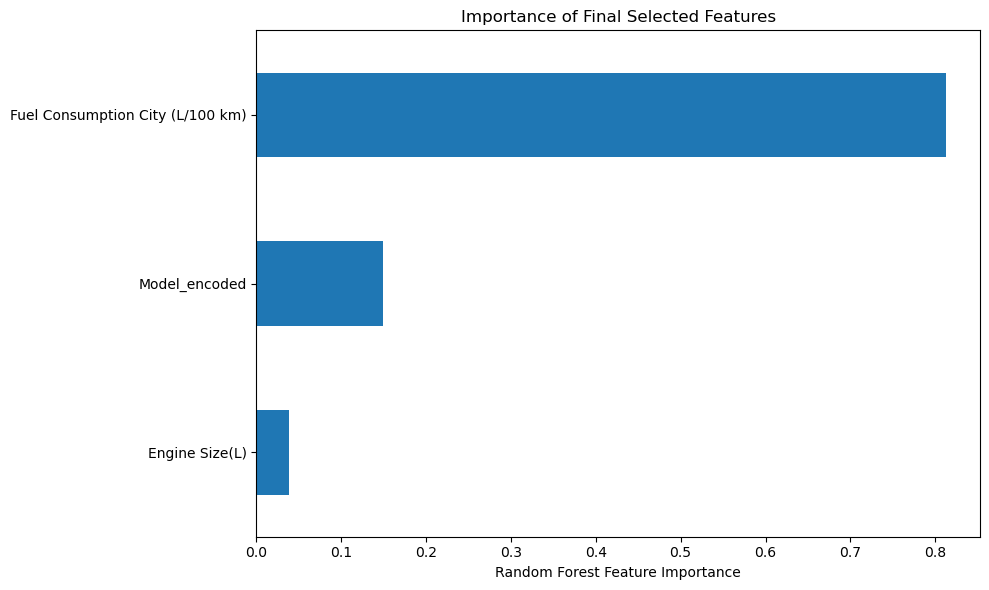

In [7]:
# -------------------- 5. Feature Selection using RFE with Random Forest --------------------
print("\n[5] Feature Selection using RFE with Random Forest - Retaining Half the Features")
X_train = train_reduced_df.drop(columns=[target])
y_train = train_reduced_df[target]
X_test = test_reduced_df.drop(columns=[target])
y_test = test_reduced_df[target]

# Use Random Forest as the base estimator
rf_selector = RandomForestRegressor(n_estimators=100, random_state=42)

# Set number of features to retain as half of the total (rounded down)
num_features_to_select = X_train.shape[1] // 2

rfe = RFE(estimator=rf_selector, n_features_to_select=num_features_to_select, step=1)

rfe.fit(X_train, y_train)

# List the best features selected by RFE
optimal_features = X_train.columns[rfe.support_].tolist()
print("Best features selected by RFE:", optimal_features)

# Print ranking of each feature (1 means selected, higher numbers mean lower importance)
ranking_series = pd.Series(rfe.ranking_, index=X_train.columns).sort_values()
print("Feature rankings:")
print(ranking_series)

# Fit a final Random Forest on the selected features and show their importances
rf_final = RandomForestRegressor(random_state=42)
rf_final.fit(X_train[optimal_features], y_train)
final_importances = pd.Series(rf_final.feature_importances_, index=optimal_features).sort_values(ascending=True)

# Plot the importance of the final selected features
plt.figure(figsize=(10, 6))
final_importances.plot(kind='barh')
plt.xlabel("Random Forest Feature Importance")
plt.title("Importance of Final Selected Features")
plt.tight_layout()
plt.show()

# Build new training and test sets with only the selected features
X_train_final = X_train[optimal_features]
X_test_final = X_test[optimal_features]


### Neural Network

In [8]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler 

In [31]:
# -------------------- 6. Neural Network Model --------------------
scaler = StandardScaler()

X_train_final = scaler.fit_transform(X_train[optimal_features])
X_test_final = scaler.fit_transform(X_test[optimal_features])
y_train = scaler.fit_transform(train_reduced_df[target].values.reshape(-1, 1))
y_test = scaler.fit_transform(test_reduced_df[target].values.reshape(-1, 1))



# X_scaled = scaler.fit_transform(X)
# y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

# Check the shape of the X and y
X_train_final.shape, X_test_final.shape, y_train.shape, y_test.shape

((5908, 3), (1477, 3), (5908, 1), (1477, 1))

In [32]:
# Login to wandb
import wandb
wandb.login(key="aecbd3b8089f86df9d26e0065887efa62f590811")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\18611\_netrc


True

In [33]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MultiLayerPerceptron, self).__init__()

        # Initialise an empty list to hold layers
        layers = []

        # First layer: input to hidden
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())

        # Additional hidden layers
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
            
        # Output layer: hidden to output
        layers.append(nn.Linear(hidden_size, output_size))
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [35]:
from torch.utils.data import DataLoader, random_split

# Calculate the sizes for train and validation splits
trainset = torch.utils.data.TensorDataset(torch.Tensor(X_train_final).float(), torch.Tensor(y_train).float())

num_total = len(trainset)
num_train = int(0.9 * num_total)
num_val = num_total - num_train

# Split the dataset
train_subset, val_subset = random_split(trainset, [num_train, num_val])

# Create DataLoaders for each subset
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

In [36]:
# Hyperparameter grid
hidden_units_options = [32, 64]
hidden_layers_options = [2, 3]
learning_rates = [0.001, 0.01]

max_epochs = 200  # Arbitrarily large; early stopping will likely stop earlier.
patience = 5      # Early stopping patience

In [37]:
# Define a helper function to run one epoch of training
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    # Iterate over the provided DataLoader
    for features, labels in dataloader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader.dataset)

In [38]:
# Define a helper function to validate the models
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for features, labels in dataloader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            running_loss += loss.item() 
    return running_loss / len(dataloader.dataset)

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [40]:
from itertools import product
import torch.optim as optim

# Run training for each of the 8 configurations
for hidden_units, hidden_layers, lr in product(hidden_units_options, hidden_layers_options, learning_rates):
    # Record configurations
    config = {
        "hidden_units": hidden_units,
        "hidden_layers": hidden_layers,
        "learning_rate": lr,
        "max_epochs": max_epochs,
        "patience": patience
    }
    # Start a new W&B run for each configuration
    wandb.init(project="nn-hyperparameter-sweep", config=config, reinit=True)
    
    # Initialize the model, loss, and optimizer
    model = MultiLayerPerceptron(input_size=3, hidden_size=hidden_units,
                               num_layers=hidden_layers, output_size=1).to(device)
    criterion = nn.MSELoss() # we use Mean Squared Error as the loss function since we are predicting a continuous variable.
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    
    for epoch in range(1, max_epochs + 1):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss = validate(model, val_loader, criterion, device)
        
        # Log metrics to W&B
        wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss})
        
        print(f"Config {config} | Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

    wandb.finish()

print("Training complete for all configurations.")

Config {'hidden_units': 32, 'hidden_layers': 2, 'learning_rate': 0.001, 'max_epochs': 200, 'patience': 5} | Epoch 001 | Train Loss: 0.0062 | Val Loss: 0.0019
Config {'hidden_units': 32, 'hidden_layers': 2, 'learning_rate': 0.001, 'max_epochs': 200, 'patience': 5} | Epoch 002 | Train Loss: 0.0013 | Val Loss: 0.0017
Config {'hidden_units': 32, 'hidden_layers': 2, 'learning_rate': 0.001, 'max_epochs': 200, 'patience': 5} | Epoch 003 | Train Loss: 0.0011 | Val Loss: 0.0014
Config {'hidden_units': 32, 'hidden_layers': 2, 'learning_rate': 0.001, 'max_epochs': 200, 'patience': 5} | Epoch 004 | Train Loss: 0.0009 | Val Loss: 0.0011
Config {'hidden_units': 32, 'hidden_layers': 2, 'learning_rate': 0.001, 'max_epochs': 200, 'patience': 5} | Epoch 005 | Train Loss: 0.0008 | Val Loss: 0.0010
Config {'hidden_units': 32, 'hidden_layers': 2, 'learning_rate': 0.001, 'max_epochs': 200, 'patience': 5} | Epoch 006 | Train Loss: 0.0008 | Val Loss: 0.0008
Config {'hidden_units': 32, 'hidden_layers': 2, 'lea

epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,56
train_loss,0.00042
val_loss,0.00047


Config {'hidden_units': 32, 'hidden_layers': 2, 'learning_rate': 0.01, 'max_epochs': 200, 'patience': 5} | Epoch 001 | Train Loss: 0.0017 | Val Loss: 0.0014
Config {'hidden_units': 32, 'hidden_layers': 2, 'learning_rate': 0.01, 'max_epochs': 200, 'patience': 5} | Epoch 002 | Train Loss: 0.0008 | Val Loss: 0.0007
Config {'hidden_units': 32, 'hidden_layers': 2, 'learning_rate': 0.01, 'max_epochs': 200, 'patience': 5} | Epoch 003 | Train Loss: 0.0006 | Val Loss: 0.0008
Config {'hidden_units': 32, 'hidden_layers': 2, 'learning_rate': 0.01, 'max_epochs': 200, 'patience': 5} | Epoch 004 | Train Loss: 0.0006 | Val Loss: 0.0006
Config {'hidden_units': 32, 'hidden_layers': 2, 'learning_rate': 0.01, 'max_epochs': 200, 'patience': 5} | Epoch 005 | Train Loss: 0.0006 | Val Loss: 0.0006
Config {'hidden_units': 32, 'hidden_layers': 2, 'learning_rate': 0.01, 'max_epochs': 200, 'patience': 5} | Epoch 006 | Train Loss: 0.0005 | Val Loss: 0.0005
Config {'hidden_units': 32, 'hidden_layers': 2, 'learning_

epoch,▁▂▂▃▄▅▅▆▇▇█
train_loss,█▃▂▂▁▁▁▂▁▁▁
val_loss,█▂▃▂▂▁▁▂▂▂▁
epoch,11
train_loss,0.0005
val_loss,0.00055


Config {'hidden_units': 32, 'hidden_layers': 3, 'learning_rate': 0.001, 'max_epochs': 200, 'patience': 5} | Epoch 001 | Train Loss: 0.0056 | Val Loss: 0.0021
Config {'hidden_units': 32, 'hidden_layers': 3, 'learning_rate': 0.001, 'max_epochs': 200, 'patience': 5} | Epoch 002 | Train Loss: 0.0014 | Val Loss: 0.0015
Config {'hidden_units': 32, 'hidden_layers': 3, 'learning_rate': 0.001, 'max_epochs': 200, 'patience': 5} | Epoch 003 | Train Loss: 0.0011 | Val Loss: 0.0012
Config {'hidden_units': 32, 'hidden_layers': 3, 'learning_rate': 0.001, 'max_epochs': 200, 'patience': 5} | Epoch 004 | Train Loss: 0.0009 | Val Loss: 0.0012
Config {'hidden_units': 32, 'hidden_layers': 3, 'learning_rate': 0.001, 'max_epochs': 200, 'patience': 5} | Epoch 005 | Train Loss: 0.0008 | Val Loss: 0.0010
Config {'hidden_units': 32, 'hidden_layers': 3, 'learning_rate': 0.001, 'max_epochs': 200, 'patience': 5} | Epoch 006 | Train Loss: 0.0007 | Val Loss: 0.0009
Config {'hidden_units': 32, 'hidden_layers': 3, 'lea

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,39
train_loss,0.00044
val_loss,0.00058


Config {'hidden_units': 32, 'hidden_layers': 3, 'learning_rate': 0.01, 'max_epochs': 200, 'patience': 5} | Epoch 001 | Train Loss: 0.0022 | Val Loss: 0.0011
Config {'hidden_units': 32, 'hidden_layers': 3, 'learning_rate': 0.01, 'max_epochs': 200, 'patience': 5} | Epoch 002 | Train Loss: 0.0008 | Val Loss: 0.0007
Config {'hidden_units': 32, 'hidden_layers': 3, 'learning_rate': 0.01, 'max_epochs': 200, 'patience': 5} | Epoch 003 | Train Loss: 0.0007 | Val Loss: 0.0007
Config {'hidden_units': 32, 'hidden_layers': 3, 'learning_rate': 0.01, 'max_epochs': 200, 'patience': 5} | Epoch 004 | Train Loss: 0.0006 | Val Loss: 0.0007
Config {'hidden_units': 32, 'hidden_layers': 3, 'learning_rate': 0.01, 'max_epochs': 200, 'patience': 5} | Epoch 005 | Train Loss: 0.0006 | Val Loss: 0.0006
Config {'hidden_units': 32, 'hidden_layers': 3, 'learning_rate': 0.01, 'max_epochs': 200, 'patience': 5} | Epoch 006 | Train Loss: 0.0006 | Val Loss: 0.0006
Config {'hidden_units': 32, 'hidden_layers': 3, 'learning_

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▃▄▃▄▅▃▃▅▂█▂▃▅▄▂▂▂▂▁▃▃▁▁▂▂▁▁▂▃▂▁▂▁▂▁▂▂
epoch,60
train_loss,0.00033
val_loss,0.00043


Config {'hidden_units': 64, 'hidden_layers': 2, 'learning_rate': 0.001, 'max_epochs': 200, 'patience': 5} | Epoch 001 | Train Loss: 0.0041 | Val Loss: 0.0017
Config {'hidden_units': 64, 'hidden_layers': 2, 'learning_rate': 0.001, 'max_epochs': 200, 'patience': 5} | Epoch 002 | Train Loss: 0.0012 | Val Loss: 0.0014
Config {'hidden_units': 64, 'hidden_layers': 2, 'learning_rate': 0.001, 'max_epochs': 200, 'patience': 5} | Epoch 003 | Train Loss: 0.0010 | Val Loss: 0.0011
Config {'hidden_units': 64, 'hidden_layers': 2, 'learning_rate': 0.001, 'max_epochs': 200, 'patience': 5} | Epoch 004 | Train Loss: 0.0008 | Val Loss: 0.0009
Config {'hidden_units': 64, 'hidden_layers': 2, 'learning_rate': 0.001, 'max_epochs': 200, 'patience': 5} | Epoch 005 | Train Loss: 0.0007 | Val Loss: 0.0007
Config {'hidden_units': 64, 'hidden_layers': 2, 'learning_rate': 0.001, 'max_epochs': 200, 'patience': 5} | Epoch 006 | Train Loss: 0.0007 | Val Loss: 0.0007
Config {'hidden_units': 64, 'hidden_layers': 2, 'lea

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
train_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,34
train_loss,0.00045
val_loss,0.00049


Config {'hidden_units': 64, 'hidden_layers': 2, 'learning_rate': 0.01, 'max_epochs': 200, 'patience': 5} | Epoch 001 | Train Loss: 0.0015 | Val Loss: 0.0011
Config {'hidden_units': 64, 'hidden_layers': 2, 'learning_rate': 0.01, 'max_epochs': 200, 'patience': 5} | Epoch 002 | Train Loss: 0.0007 | Val Loss: 0.0008
Config {'hidden_units': 64, 'hidden_layers': 2, 'learning_rate': 0.01, 'max_epochs': 200, 'patience': 5} | Epoch 003 | Train Loss: 0.0007 | Val Loss: 0.0006
Config {'hidden_units': 64, 'hidden_layers': 2, 'learning_rate': 0.01, 'max_epochs': 200, 'patience': 5} | Epoch 004 | Train Loss: 0.0006 | Val Loss: 0.0012
Config {'hidden_units': 64, 'hidden_layers': 2, 'learning_rate': 0.01, 'max_epochs': 200, 'patience': 5} | Epoch 005 | Train Loss: 0.0006 | Val Loss: 0.0007
Config {'hidden_units': 64, 'hidden_layers': 2, 'learning_rate': 0.01, 'max_epochs': 200, 'patience': 5} | Epoch 006 | Train Loss: 0.0006 | Val Loss: 0.0008
Config {'hidden_units': 64, 'hidden_layers': 2, 'learning_

epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
train_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂
val_loss,▇▄▂█▃▄▄▂▁▂▂▂▁▁▂▂▅▁
epoch,18
train_loss,0.00055
val_loss,0.0005


Config {'hidden_units': 64, 'hidden_layers': 3, 'learning_rate': 0.001, 'max_epochs': 200, 'patience': 5} | Epoch 001 | Train Loss: 0.0030 | Val Loss: 0.0014
Config {'hidden_units': 64, 'hidden_layers': 3, 'learning_rate': 0.001, 'max_epochs': 200, 'patience': 5} | Epoch 002 | Train Loss: 0.0009 | Val Loss: 0.0010
Config {'hidden_units': 64, 'hidden_layers': 3, 'learning_rate': 0.001, 'max_epochs': 200, 'patience': 5} | Epoch 003 | Train Loss: 0.0007 | Val Loss: 0.0008
Config {'hidden_units': 64, 'hidden_layers': 3, 'learning_rate': 0.001, 'max_epochs': 200, 'patience': 5} | Epoch 004 | Train Loss: 0.0007 | Val Loss: 0.0007
Config {'hidden_units': 64, 'hidden_layers': 3, 'learning_rate': 0.001, 'max_epochs': 200, 'patience': 5} | Epoch 005 | Train Loss: 0.0006 | Val Loss: 0.0007
Config {'hidden_units': 64, 'hidden_layers': 3, 'learning_rate': 0.001, 'max_epochs': 200, 'patience': 5} | Epoch 006 | Train Loss: 0.0006 | Val Loss: 0.0006
Config {'hidden_units': 64, 'hidden_layers': 3, 'lea

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▂▁▁▂▂
epoch,26
train_loss,0.00043
val_loss,0.00054


Config {'hidden_units': 64, 'hidden_layers': 3, 'learning_rate': 0.01, 'max_epochs': 200, 'patience': 5} | Epoch 001 | Train Loss: 0.0018 | Val Loss: 0.0009
Config {'hidden_units': 64, 'hidden_layers': 3, 'learning_rate': 0.01, 'max_epochs': 200, 'patience': 5} | Epoch 002 | Train Loss: 0.0007 | Val Loss: 0.0007
Config {'hidden_units': 64, 'hidden_layers': 3, 'learning_rate': 0.01, 'max_epochs': 200, 'patience': 5} | Epoch 003 | Train Loss: 0.0007 | Val Loss: 0.0010
Config {'hidden_units': 64, 'hidden_layers': 3, 'learning_rate': 0.01, 'max_epochs': 200, 'patience': 5} | Epoch 004 | Train Loss: 0.0006 | Val Loss: 0.0006
Config {'hidden_units': 64, 'hidden_layers': 3, 'learning_rate': 0.01, 'max_epochs': 200, 'patience': 5} | Epoch 005 | Train Loss: 0.0006 | Val Loss: 0.0006
Config {'hidden_units': 64, 'hidden_layers': 3, 'learning_rate': 0.01, 'max_epochs': 200, 'patience': 5} | Epoch 006 | Train Loss: 0.0005 | Val Loss: 0.0005
Config {'hidden_units': 64, 'hidden_layers': 3, 'learning_

epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
train_loss,█▂▂▂▂▁▁▁▁▁▁▁▂▂▁▁
val_loss,▆▄█▂▃▁▄▄▂▂▁▂▃▁▁▁
epoch,16
train_loss,0.00046
val_loss,0.00053


Training complete for all configurations.


we finally choose 'hidden_units': 32, 'hidden_layers': 2, 'learning_rate': 0.001, 'max_epochs': 200, 'patience': 5 as our best model

## K-fold Cross Validation

In [ ]:
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold

# Define a helper function to validate the models
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for features, labels in dataloader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            running_loss += loss.item() 
    return running_loss / len(dataloader.dataset)

# Define the model architectures using lambdas to easily reinitialize per fold
model = MultiLayerPerceptron(input_size=3, hidden_size=32,
                               num_layers=2, output_size=1).to(device)

# Set up K-Fold Cross Validation (K=5)
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)

# Number of epochs per fold
# We are using the number of epoches according to the best model from wandb
num_epochs = 56

for model_name, model_fn in models.items():
    print(f"Cross Validation for {model_name}")
    
    fold_train_losses = []
    fold_val_losses = []
    fold_number = 1
    
    for train_idx, val_idx in kfold.split(range(len(trainset))):
        print(f"  Fold {fold_number}")
        # Create subsets for training and validation data for this fold
        train_subset = Subset(trainset, train_idx)
        val_subset = Subset(trainset, val_idx)
        
        trainloader = DataLoader(train_subset, batch_size=64, shuffle=True)
        valloader = DataLoader(val_subset, batch_size=64, shuffle=False)
        
        # Initialize model, loss function, and optimizer for this fold
        model = model_fn().to(device)
        criterion = nn.MSELoss() # we use Mean Squared Error as the loss function since we are predicting a continuous variable.
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # Train for the specified number of epochs and evaluate after each epoch
        for epoch in range(num_epochs):
            train_loss = train_epoch(model, trainloader, criterion, optimizer, device)
            val_loss = validate(model, valloader, criterion, device)
            print(f"    Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}")
        
        fold_train_losses.append(train_loss)
        fold_val_losses.append(val_loss)
        fold_number += 1
        
    overall_train_loss = sum(fold_train_losses) / k_folds
    overall_val_loss = sum(fold_val_losses) / k_folds
    print(f"Overall {model_name} - Train Loss: {overall_train_loss:.4f} | Validation Loss: {overall_val_loss:.4f}\n")

print("Cross-validation complete.")




Cross Validation for Model
  Fold 1
    Epoch 1/56 - Train Loss: 0.0191 | Validation Loss: 0.0179
    Epoch 2/56 - Train Loss: 0.0167 | Validation Loss: 0.0162
    Epoch 3/56 - Train Loss: 0.0154 | Validation Loss: 0.0150
    Epoch 4/56 - Train Loss: 0.0141 | Validation Loss: 0.0136
    Epoch 5/56 - Train Loss: 0.0126 | Validation Loss: 0.0119
    Epoch 6/56 - Train Loss: 0.0109 | Validation Loss: 0.0103
    Epoch 7/56 - Train Loss: 0.0094 | Validation Loss: 0.0090
    Epoch 8/56 - Train Loss: 0.0082 | Validation Loss: 0.0079
    Epoch 9/56 - Train Loss: 0.0073 | Validation Loss: 0.0071
    Epoch 10/56 - Train Loss: 0.0066 | Validation Loss: 0.0064
    Epoch 11/56 - Train Loss: 0.0060 | Validation Loss: 0.0059
    Epoch 12/56 - Train Loss: 0.0055 | Validation Loss: 0.0055
    Epoch 13/56 - Train Loss: 0.0051 | Validation Loss: 0.0051
    Epoch 14/56 - Train Loss: 0.0048 | Validation Loss: 0.0048
    Epoch 15/56 - Train Loss: 0.0045 | Validation Loss: 0.0045
    Epoch 16/56 - Train Loss

R²: 0.9132
MSE: 0.0985
MAE: 0.1898


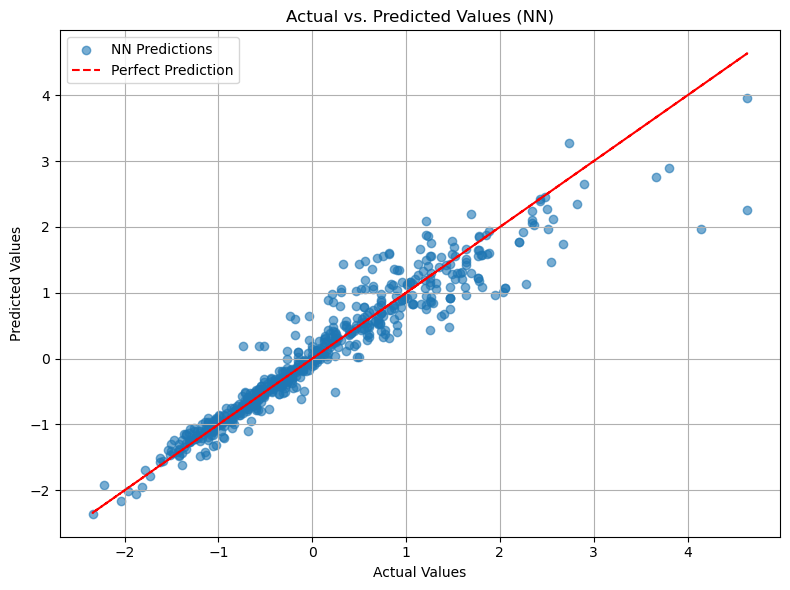

In [73]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Convert predictions and actual values to numpy arrays
y_test_actual = np.array(val_actuals).flatten()
y_test_pred = np.array(val_predictions).flatten()

# Calculate metrics
r2 = r2_score(y_test_actual, y_test_pred)
mse = mean_squared_error(y_test_actual, y_test_pred)
mae = mean_absolute_error(y_test_actual, y_test_pred)

# Print the results
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")


# ensure the length of the actual and predicted values are the same
min_length = min(len(y_test_actual), len(nn_predictions))
y_test_actual_trimmed = y_test_actual[:min_length]
nn_predictions_trimmed = nn_predictions[:min_length]

# plot the actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_actual_trimmed, nn_predictions_trimmed, alpha=0.6, label="NN Predictions")
plt.plot(y_test_actual_trimmed, y_test_actual_trimmed, 'r--', label="Perfect Prediction")  # 完美预测线
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values (NN)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Model Evaluation for NN and the rest regression models


Model Performance Metrics:
Ridge Regression: MSE = 35.0081, R² = 0.9898, MAE = 3.0987
Random Forest: MSE = 16.6987, R² = 0.9951, MAE = 1.9831
Support Vector Regression (SVR): MSE = 14.2747, R² = 0.9958, MAE = 1.9223

MAE Array: [-3.09871692 -1.98305846 -1.92225558]


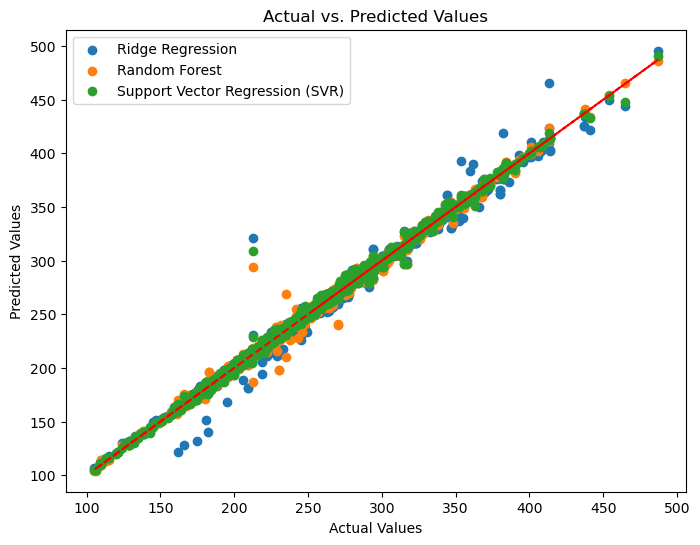

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# choose the target and features
target = "CO2 Emissions(g/km)"
numerical_features = ["Engine Size(L)", "Cylinders", 
                      "Fuel Consumption City (L/100 km)", 
                      "Fuel Consumption Hwy (L/100 km)", 
                      "Fuel Consumption Comb (L/100 km)"]
categorical_features = ["Vehicle Class", "Transmission", "Fuel Type"]

# Ensure the categorical columns exist in the DataFrame
if not all(col in data_df.columns for col in categorical_features):
    raise KeyError(f"One or more categorical columns are missing in the DataFrame: {categorical_features}")

# OneHotEncoding for categorical features
encoder = OneHotEncoder(drop="first", sparse=False)
encoded_categorical = encoder.fit_transform(data_df[categorical_features])

# Get the feature names for the encoded categorical features
encoded_feature_names = encoder.get_feature_names_out(categorical_features)

# Create a new DataFrame with the numerical features and the encoded categorical features
X = np.hstack((data_df[numerical_features].values, encoded_categorical))
X = pd.DataFrame(X, columns=numerical_features + list(encoded_feature_names))
y = data_df[target]

# Standardize the numerical features
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the models to evaluate
models = {
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Support Vector Regression (SVR)": SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
}

# Fit the models and make predictions
predictions = {}
metrics = {}
mae_list = []

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions[name] = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, predictions[name])
    r2 = r2_score(y_test, predictions[name])
    mae = mean_absolute_error(y_test, predictions[name])
    
    # Store the metrics
    metrics[name] = {"MSE": mse, "R²": r2, "MAE": mae}
    mae_list.append(mae)

# Convert MAE list to a numpy array and invert the values
mae_array = np.array(mae_list) * (-1)

# Print the model performance metrics
print("\nModel Performance Metrics:")
for name, metric in metrics.items():
    print(f"{name}: MSE = {metric['MSE']:.4f}, R² = {metric['R²']:.4f}, MAE = {metric['MAE']:.4f}")

# Print the MAE array
print("\nMAE Array:", mae_array)

# Plot the MAE array
plt.figure(figsize=(8, 6))
for name, preds in predictions.items():
    plt.scatter(y_test, preds, label=f"{name}")

plt.plot(y_test, y_test, 'r--')  # Perfect predictions
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()



Model Performance Metrics:
Ridge Regression: MSE = 35.0081, R² = 0.9898, MAE = 3.0987
Random Forest: MSE = 16.6987, R² = 0.9951, MAE = 1.9831
Support Vector Regression (SVR): MSE = 14.2747, R² = 0.9958, MAE = 1.9223
Neural Network: MSE = 0.0985, R² = 0.9132, MAE = 0.1898

MAE Array: [-3.09871692 -1.98305846 -1.92225558 -0.18979929]


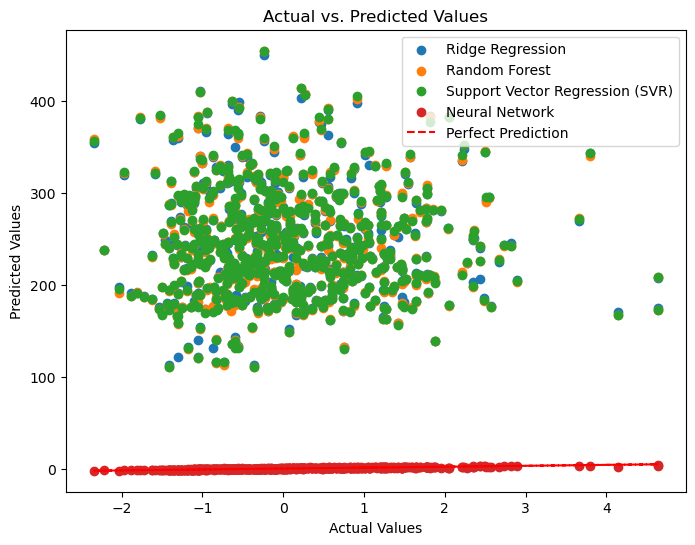

In [ ]:
# Convert predictions and actual values to numpy arrays
y_test_actual = np.array(val_actuals).flatten()
nn_predictions = np.array(val_predictions).flatten()

# Ensure the lengths of the actual and predicted values are the same
min_length = min(y_test_actual.shape[0], nn_predictions.shape[0])
y_test_actual = y_test_actual[:min_length]
nn_predictions = nn_predictions[:min_length]

# Plot the actual vs predicted values
predictions["Neural Network"] = nn_predictions

# Calculate metrics for the Neural Network model
metrics["Neural Network"] = {
    "MSE": mean_squared_error(y_test_actual, predictions["Neural Network"]),
    "R²": r2_score(y_test_actual, predictions["Neural Network"]),
    "MAE": mean_absolute_error(y_test_actual, predictions["Neural Network"]),
}

# Append the MAE to the list
mae_list.append(metrics["Neural Network"]["MAE"])
mae_array = np.array(mae_list) * (-1)

# Print the model performance metrics
print("\nModel Performance Metrics:")
for name, metric in metrics.items():
    print(f"{name}: MSE = {metric['MSE']:.4f}, R² = {metric['R²']:.4f}, MAE = {metric['MAE']:.4f}")

# Print the MAE array
print("\nMAE Array:", mae_array)

# Plot the MAE array
plt.figure(figsize=(8, 6))
for name, preds in predictions.items():
    if y_test_actual.shape[0] != preds.shape[0]:
        print(f"Warning: {name} has mismatched shape! Adjusting...")
        min_length = min(y_test_actual.shape[0], preds.shape[0])
        preds = preds[:min_length]  # Trim the predictions to match the actual values
        y_test_actual = y_test_actual[:min_length]

    plt.scatter(y_test_actual, preds, label=f"{name}")

plt.plot(y_test_actual, y_test_actual, 'r--', label="Perfect Prediction")  # Perfect predictions
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()
